<summary>
    <font size="5" color="gray"><b> CONVENIO CENACE-UNISON 2023-2025
 </b></font>
</summary><br>
<summary>
    <font size="4" color="orange"><b> DESARROLLO DE PROTOTIPO: METODOLOGÍA CON APRENDIZAJE PROFUNDO PARA EL PRONÓSTICO A CORTO PLAZO DE DEMANDA DE ENERGÍA CON DATOS EN ADELANTO.
 </b></font>
</summary>



---

<summary>
    <font size="6" color="gray"><b> Libreta JNB2: Entrenamiento 
 </b></font>
</summary>
<summary>
    <font size="5" color="gray"><b> Modelado parte 2
 </b></font>
</summary>

--- 

<summary>
 <font size="4" color="lightblue"><b> MODELO ENCODER-DECODER TODAS LAS VARIABLES EN ADELANTO </b></font>
 </b></font>
</summary>

---


    
    
OLIVIA CAROLINA GUTÚ OCAMPO

REYNA YANET HERNÁNDEZ MADA

JULIO WAISSMAN VILANOVA (Responsable del proyecto)


---


<summary>
    <font size="4" color="orange"><b> INPUTS
 </b></font>
</summary>

  * **'./internal_inputs/TENSORS/X_encoder_train.npy'** 
   * **'./internal_inputs/TENSORS/X_decoder_train.npy'** 
   * **'./internal_inputs/TENSORS/y_train.npy'** 
   * **'./internal_inputs/TENSORS/X_encoder_val.npy'** 
   * **'./internal_inputs/TENSORS/X_decoder_val.npy'** 
   * **'./internal_inputs/TENSORS/y_val.npy'** 
   * **'./internal_inputs/TENSORS/X_encoder_test.npy'** 
   * **'./internal_inputs/TENSORS/X_decoder_test.npy'** 
   * **'./internal_inputs/TENSORS/y_test.npy'** 

--- 
<summary>
    <font size="4" color="orange"><b> CHECK POINTS
 </b></font>
</summary>

   * Verificación de curvas de aprendizaje.
    
   * Verificación de desempeño (MAPE) sobre el conjunto de prueba.

---
<summary>
    <font size="4" color="orange"><b> OUTPUTS
 </b></font>
</summary>

Se exportan finalmente, el pronóstico sobre el tensor de datos de prueba (antes del escalamiento final), las curvas de aprendizaje y el modelo.
    
   *  **'./outputs/MODEL/y_estimado_antes_minmax.npy'**
   *  **'./outputs/MODEL/training_loss.npy'**
   *  **'./outputs/MODEL/val_loss.npy'**
   *  **'./outputs/MODEL/modelo.h5'**


## 1.   Importación de librerías 

In [1]:
# librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# librerías de normalización
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Tensorflow y keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Auxiliar libraries
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
import pickle as pk
import scipy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## 2.  Importando tensores de entrada

In [2]:
#importación de tensores
X_encoder_train = np.load('./internal_inputs/TENSORS/X_encoder_train.npy')
X_decoder_train = np.load('./internal_inputs/TENSORS/X_decoder_train.npy')
y_train = np.load('./internal_inputs/TENSORS/y_train.npy')
X_encoder_val = np.load('./internal_inputs/TENSORS/X_encoder_val.npy')
X_decoder_val = np.load('./internal_inputs/TENSORS/X_decoder_val.npy')
y_val = np.load('./internal_inputs/TENSORS/y_val.npy')
X_encoder_test = np.load('./internal_inputs/TENSORS/X_encoder_test.npy')
X_decoder_test = np.load('./internal_inputs/TENSORS/X_decoder_test.npy') 
y_test = np.load('./internal_inputs/TENSORS/y_test.npy')

## 3.   Ajuste de modelo

In [3]:
## Setting the features
all_features = ['Energy_Demand', 
                'Day', 
                'Hour', 
                'Month', 
                'PC1_Weather',
                'Monday_Holiday', 
                'Tuesday_Aft_Hol', 
                'Easter_week',
                'May_1s', 
                'May_10t', 
                'Sept_16', 
                'Nov_2nd', 
                'Before_Christmas_NY',
                'Christmas_NY', 
                'After_Christmas_NY'
               ]

In [4]:
#Ajuste de hiperparámetros
n_pasado = (24 * 7) + 12
n_futuro = 36 
m = len(all_features)

In [5]:
# Ajuste encoder
encoder_inputs = layers.Input(shape=(n_pasado, m))

encoder_l1 = layers.LSTM(100, return_state=True)# 100: dimension of hidden states
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

# Ajuste decoder
decoder_rvec = layers.RepeatVector(n_futuro) # repeat vector 24 times
decoder_inputs = decoder_rvec(encoder_outputs1[0])

decoder_l1 = layers.LSTM(100, return_sequences=True)
decoder_l1_output = decoder_l1(decoder_inputs, initial_state=encoder_states1)

decoder_l2 = layers.TimeDistributed(layers.Dense(1)) # just one dense layer
decoder_outputs = decoder_l2(decoder_l1_output)

In [6]:
modelo = keras.models.Model(encoder_inputs, decoder_outputs)
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 15)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        46400       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 36, 100)      0           ['lstm[0][0]']                   
                                                                                              

## 4.   Entrenamiento del  modelo

In [7]:
#Learning rate es menor en cada epoch
reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x) 

## Se guarda el mejor modelo, de acuerdo a "val_loss"
path_checkpoint = './outputs/MODEL/model_checkpoint.h5'
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor = 'val_loss',
    filepath = path_checkpoint,
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
)

## Para evitar overfitting, se detiene el entrenamiento despues
# # de epochs sin mejora, de acuerdo a "val_loss"
es_callback = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0, 
    patience = 5 
    
)
modelo.compile(
    optimizer = keras.optimizers.Adam(), 
    loss = 'mae', 
)

history = modelo.fit(
    X_encoder_train, y_train,
    epochs = 25, 
    validation_data = (X_encoder_val, y_val),
    batch_size = 32,
    callbacks = [reduce_lr, es_callback]
) 

if es_callback.stopped_epoch < 25:
    print("Model stopped training early at epoch", es_callback.stopped_epoch + 1)
else:
    print("Model completed training for all 25 epochs")

Epoch 1/25
3694/3694 [==============================] - 47s 12ms/step - loss: 0.0427 - val_loss: 0.0977 - lr: 0.0010
Epoch 2/25
3694/3694 [==============================] - 43s 12ms/step - loss: 0.0317 - val_loss: 0.0756 - lr: 9.0000e-04
Epoch 3/25
3694/3694 [==============================] - 43s 12ms/step - loss: 0.0291 - val_loss: 0.0792 - lr: 8.1000e-04
Epoch 4/25
3694/3694 [==============================] - 43s 12ms/step - loss: 0.0275 - val_loss: 0.0675 - lr: 7.2900e-04
Epoch 5/25
3694/3694 [==============================] - 43s 12ms/step - loss: 0.0263 - val_loss: 0.0729 - lr: 6.5610e-04
Epoch 6/25
3694/3694 [==============================] - 43s 12ms/step - loss: 0.0255 - val_loss: 0.0750 - lr: 5.9049e-04
Epoch 7/25
3694/3694 [==============================] - 43s 12ms/step - loss: 0.0247 - val_loss: 0.0690 - lr: 5.3144e-04
Epoch 8/25
3694/3694 [==============================] - 43s 12ms/step - loss: 0.0241 - val_loss: 0.0692 - lr: 4.7830e-04
Epoch 9/25
3694/3694 [==============

## 5.   Check point: verificar learning curves

<Figure size 640x480 with 0 Axes>

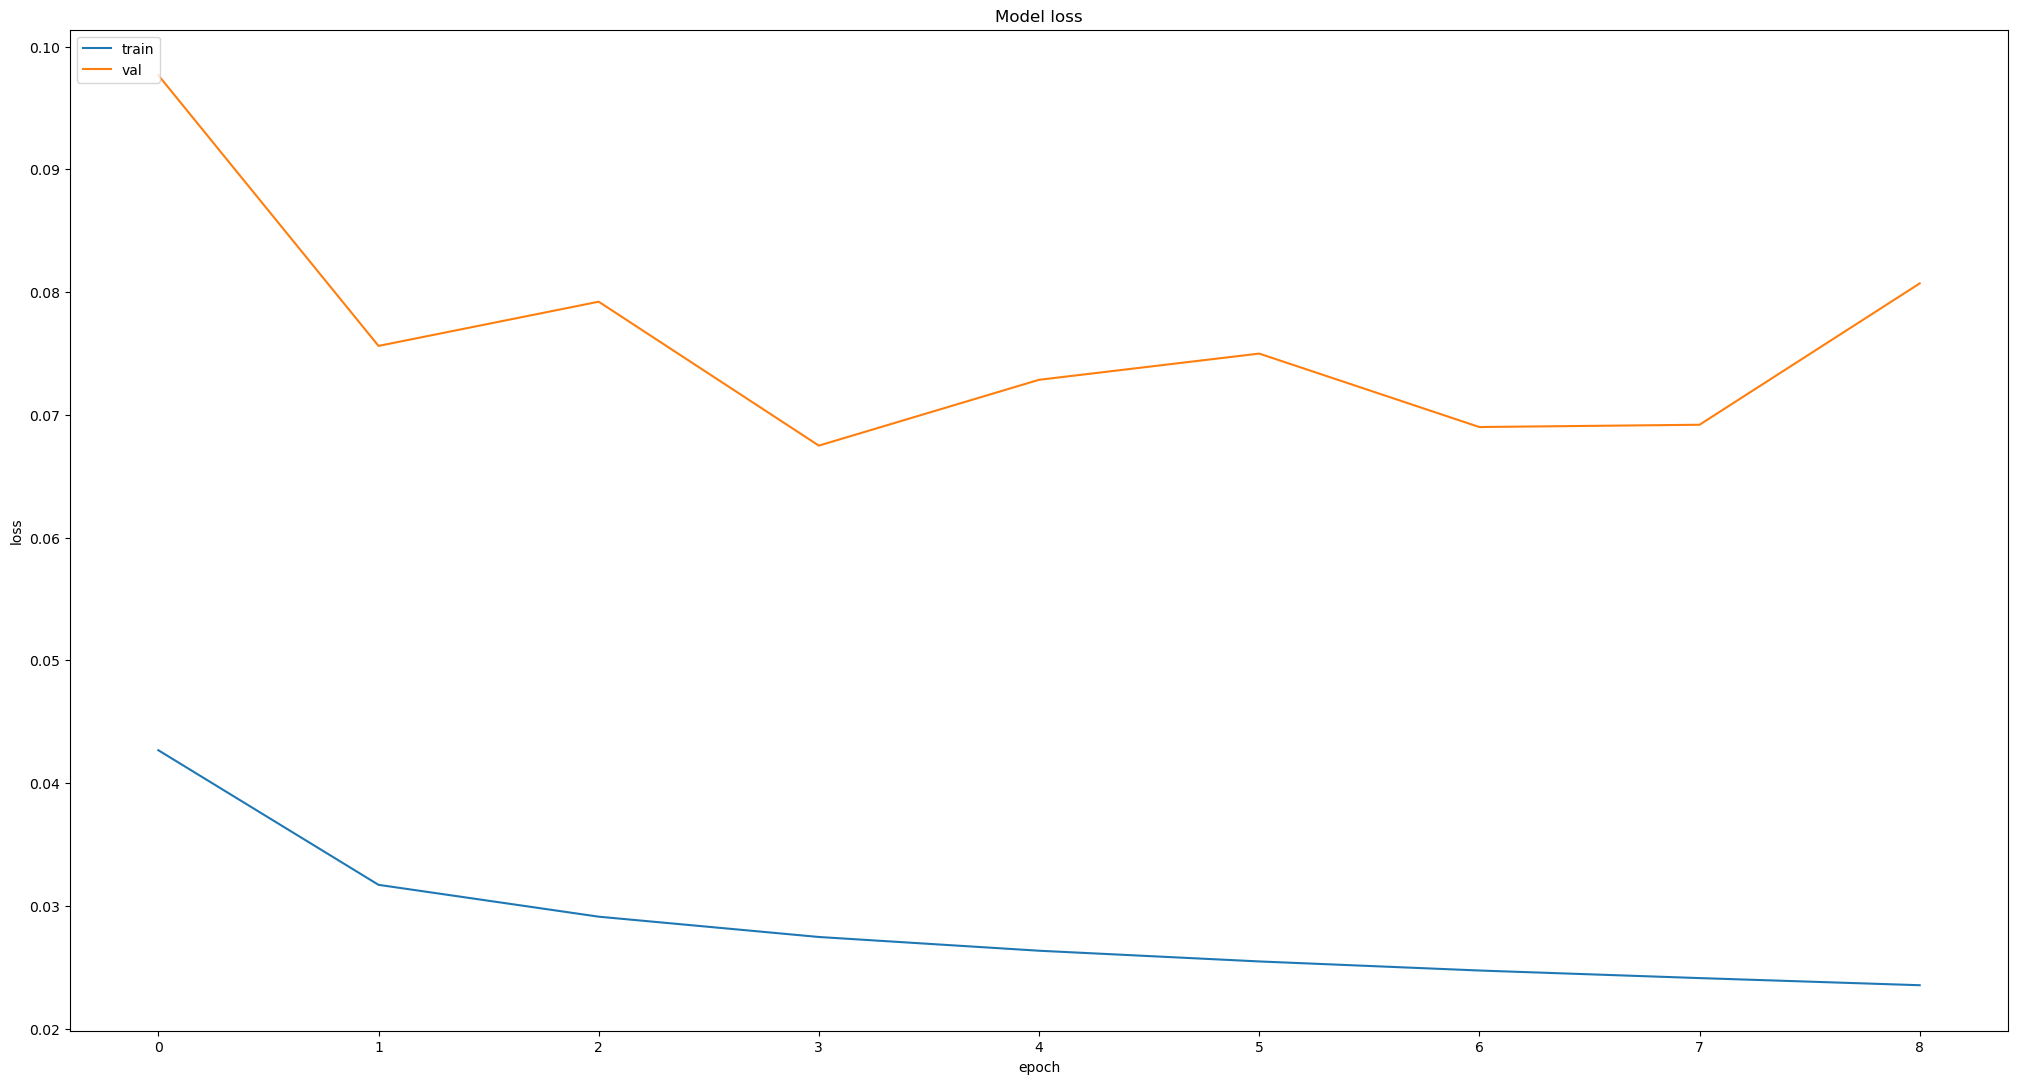

In [8]:
# Model Loss Chart
fig = plt.figure()
plt.figure(figsize=(25, 13))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [9]:
# Exportar loss values durante el entrenamiento por  epoch
np.save('./outputs/MODEL/training_loss.npy', history.history['loss'])
np.save('./outputs/MODEL/val_loss.npy', history.history['val_loss'])

## 6.   Check point: verificar performance  set de prueba

In [10]:
y_est = modelo.predict(X_encoder_test)

17/17 [==============================] - 1s 4ms/step


In [11]:
#Exportar el tensor de pronóstico antes de  transformar al  scaler original
np.save('./outputs/MODEL/y_estimado_antes_minmax.npy', y_est)

In [12]:
scalers = pk.load(open("./internal_inputs/MINMAX/scalers.pkl",'rb'))
scaler = scalers['Energy_Demand']

In [13]:
scalers = pk.load(open("./internal_inputs/MINMAX/scalers.pkl",'rb'))


In [14]:
scalers

{'Energy_Demand': MinMaxScaler(feature_range=(-1, 1)),
 'Day': MinMaxScaler(feature_range=(-1, 1)),
 'Hour': MinMaxScaler(feature_range=(-1, 1)),
 'Month': MinMaxScaler(feature_range=(-1, 1)),
 'PC1_Weather': MinMaxScaler(feature_range=(-1, 1)),
 'Monday_Holiday': MinMaxScaler(feature_range=(-1, 1)),
 'Tuesday_Aft_Hol': MinMaxScaler(feature_range=(-1, 1)),
 'Easter_week': MinMaxScaler(feature_range=(-1, 1)),
 'May_1s': MinMaxScaler(feature_range=(-1, 1)),
 'May_10t': MinMaxScaler(feature_range=(-1, 1)),
 'Sept_16': MinMaxScaler(feature_range=(-1, 1)),
 'Nov_2nd': MinMaxScaler(feature_range=(-1, 1)),
 'Before_Christmas_NY': MinMaxScaler(feature_range=(-1, 1)),
 'Christmas_NY': MinMaxScaler(feature_range=(-1, 1)),
 'After_Christmas_NY': MinMaxScaler(feature_range=(-1, 1))}

(array([104., 142.,  95.,  88.,  44.,  27.,  21.,   2.,   2.,   4.]),
 array([ 1.22164335,  2.27605582,  3.3304683 ,  4.38488077,  5.43929324,
         6.49370572,  7.54811819,  8.60253066,  9.65694314, 10.71135561,
        11.76576808]),
 <BarContainer object of 10 artists>)

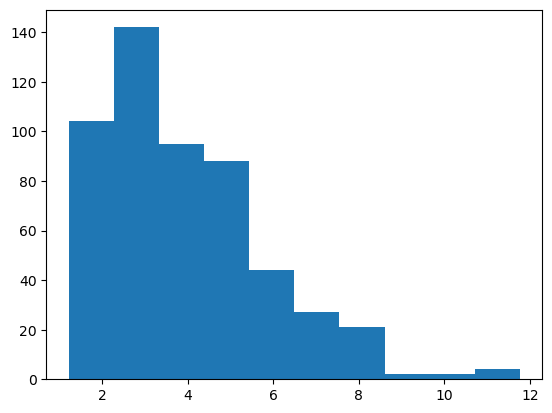

In [15]:
n = y_est.shape[0]
forecast_mape = []
for i in range(n):
    y_test_original = scaler.inverse_transform(y_test[i-1])
    y_est_final = scaler.inverse_transform(y_est[i-1])
    mape = mean_absolute_percentage_error(y_test_original,y_est_final) * 100
    forecast_mape.append(mape)
plt.hist(forecast_mape)

In [16]:

#DataFrame from the MAPE values
mape_df = pd.DataFrame(forecast_mape, columns=['MAPE (%)'])

# Display the DataFrame
print(mape_df.describe()) 

         MAPE (%)
count  529.000000
mean     3.962840
std      1.886064
min      1.221643
25%      2.532744
50%      3.573052
75%      4.989308
max     11.765768


In [19]:
mape_df.to_csv('mape_modelo5_TED.csv')

## 7.   Guardado de modelo

In [18]:
modelo.save('./outputs/MODEL/modelo2_100_V.h5')

<summary>
    <font size="4" color="gray"> Maestría en Ciencia de Datos | Universidad de Sonora </font>
</summary>
<font size="1" color="gray"> Blvd. Luis Encinas y Rosales s/n Col. Centro. Edificio 3K1 planta baja C.P. 83000, Hermosillo, Sonora, México </font>
<font size="1" color="gray"> mcd@unison.mx </font>
<font size="1" color="gray"> Tel: +52 (662) 259 2155  </font>